In [11]:
%pip install numpy pandas seaborn matplotlib 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
import subprocess

num_steps_users = 12  # Number of steps for users
num_steps_sizes = 24  # Number of steps for payload sizes
run_time_seconds = 30  # Number of seconds to run each test
num_workers = 4 # Number of workers to use for each test

num_users_list = np.array([64])
payload_sizes = np.unique(np.logspace(0, 20, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values


# fix user, small files between 1byte and 100kb
#min_size_log2 = 0  # log2(1 byte)
#max_size_log2 = log(100 * 1024, 2)  # log2(100 KB)
#num_steps_sizes = 32  # Number of steps for payload sizes
#payload_sizes = np.unique(np.logspace(min_size_log2, max_size_log2, num=num_steps_sizes, base=2).astype(int))
#num_users_list = np.full(1, 500)

In [13]:

tasks = []
for payload_size in payload_sizes:
    for num_users in num_users_list:
        task = {
            "num_users": num_users,
            "spawn_rate": num_users,  # Adjust as needed
            "payload_size": payload_size,
            "csv_filename": f"results_{payload_size}_{num_users}"
        }
        tasks.append(task)

# View first 5 tasks as an example
tasks_df = pd.DataFrame(tasks)

pd.set_option('display.max_rows', None)
print(tasks_df)
pd.reset_option('display.max_rows')


    num_users  spawn_rate  payload_size        csv_filename
0          64          64             1        results_1_64
1          64          64             3        results_3_64
2          64          64             6        results_6_64
3          64          64            11       results_11_64
4          64          64            20       results_20_64
5          64          64            37       results_37_64
6          64          64            67       results_67_64
7          64          64           124      results_124_64
8          64          64           226      results_226_64
9          64          64           414      results_414_64
10         64          64           757      results_757_64
11         64          64          1384     results_1384_64
12         64          64          2528     results_2528_64
13         64          64          4620     results_4620_64
14         64          64          8442     results_8442_64
15         64          64         15425 

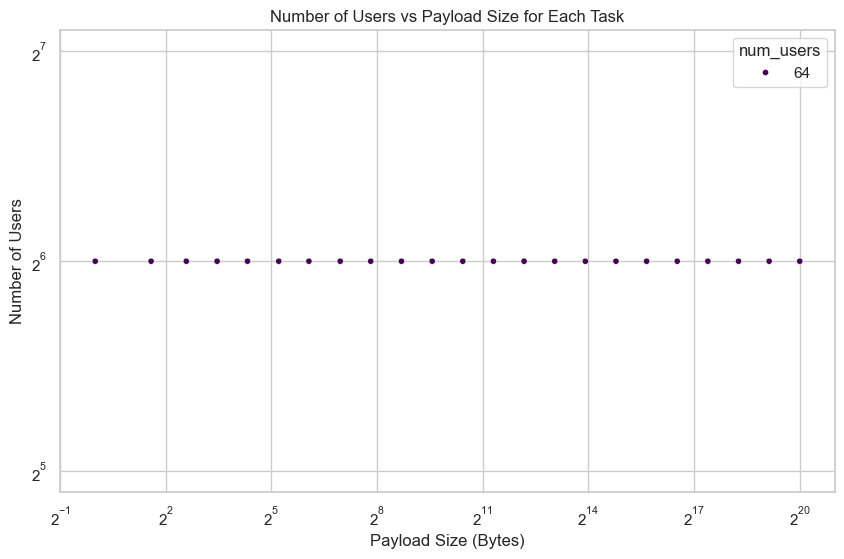

In [14]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=tasks_df, x='payload_size', y='num_users', size='num_users', hue='num_users', palette='viridis', sizes=(20, 200))

# Set the scale of the x/y-axis to logarithmic to better visualize the data
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

# Set plot labels and title
ax.set_xlabel('Payload Size (Bytes)')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Payload Size for Each Task')

# Show the plot
plt.show()

In [15]:
def run_benchmark_docker(task):
    results_file_path = f"results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f".{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Set environment variables
    os.environ['NUM_USERS'] = str(task['num_users'])
    os.environ['SPAWN_RATE'] = str(task['spawn_rate'])
    os.environ['RUN_TIME'] = str(run_time_seconds)
    os.environ['CSV_FILENAME'] = results_file_path
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Run the benchmark using Docker Compose
    subprocess.run(["docker", "compose", "up", "--scale", f"locust-worker={num_workers}"], check=True)

    # Optionally, you can stop and remove containers if needed
    subprocess.run(["docker-compose", "down"], check=True)


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

#for task in tasks:
#    run_benchmark_docker(task)

In [16]:
def run_benchmark_local(task):
    results_file_path = f".results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f"{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Command to start the Locust master
    master_command = ["locust", "-f", "../locust/locustfile.py", "--master", "--headless", 
                      "--expect-workers", "4",
                      "--host", "http://192.168.1.105:8000", 
                      "-u", str(task['num_users']), 
                      "-r", str(task['spawn_rate']), 
                      "--run-time", str(run_time_seconds),
                      "--csv", results_file_path]

    # Commands to start Locust workers
    worker_commands = [
        ["locust", "-f", "../locust/locustfile.py", "--worker", "--master-host", "127.0.0.1"] for _ in range(num_workers)
    ]

    # Start the Locust master
    master_process = subprocess.Popen(master_command)

    # Start the worker processes
    worker_processes = [subprocess.Popen(cmd) for cmd in worker_commands]
    
    try:
        # Wait for the master process to complete
        master_process.wait()
    except KeyboardInterrupt:
        # Handle Ctrl+C
        pass
    finally:
        # Terminate all processes
        master_process.terminate()
        for worker in worker_processes:
            worker.terminate()


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

for task in tasks:
    run_benchmark_local(task)

payload_size: 1payload_size: 1

payload_size: 1
payload_size: 1
payload_size: 1


[2023-11-12 21:41:41,472] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:41:41,477] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_2649fff1adb04570a11f9693ed4dd308 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:41:41,477] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 3payload_size: 3

payload_size: 3
payload_size: 3
payload_size: 3


[2023-11-12 21:42:14,664] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:42:14,667] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_0740485c63614216a77e046ad376256a (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:42:14,667] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 6
payload_size: 6
payload_size: 6
payload_size: 6
payload_size: 6


[2023-11-12 21:42:47,818] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:42:47,823] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_1e69565eaa9543a5af7d6b205b781fc1 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:42:47,823] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 11
payload_size: 11
payload_size: 11
payload_size: 11
payload_size: 11


[2023-11-12 21:43:20,989] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-12 21:43:20,991] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_1aef3309df124ac19facdc28d6e114e6 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:43:20,993] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 20
payload_size: 20
payload_size: 20
payload_size: 20
payload_size: 20


[2023-11-12 21:43:54,143] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:43:54,146] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_778dba1ff86f4670ba5c5f8e275a2165 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:43:54,146] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 37payload_size: 37

payload_size: 37
payload_size: 37
payload_size: 37


[2023-11-12 21:44:27,298] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:44:27,301] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_9044588a6e5c48fd94f9c4e4396b01b2 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:44:27,301] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67


[2023-11-12 21:45:00,443] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:45:00,449] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_ad7c61eb971a43809ffc2e54b608e7d9 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:45:00,449] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124


[2023-11-12 21:45:33,598] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-12 21:45:33,600] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_88ea54753e1c45e781d2ddbee57ddda3 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:45:33,602] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 226
payload_size: 226
payload_size: 226
payload_size: 226
payload_size: 226


[2023-11-12 21:46:06,746] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:46:06,751] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_7db7485de58d42639da63a29821333de (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:46:06,752] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414


[2023-11-12 21:46:39,912] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:46:39,915] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_8fe855eb8780426bb331b7f8a31163ee (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:46:39,915] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 757
payload_size: 757
payload_size: 757
payload_size: 757
payload_size: 757


[2023-11-12 21:47:13,077] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:47:13,080] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_e8cd1c8d216a42f7ac7a90b7cf3bcbe2 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:47:13,080] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 1384payload_size: 1384

payload_size: 1384
payload_size: 1384
payload_size: 1384


[2023-11-12 21:47:46,269] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:47:46,272] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_4899b572bbd8470f82bdd2475af822b8 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:47:46,272] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 2528payload_size: 2528

payload_size: 2528
payload_size: 2528
payload_size: 2528


[2023-11-12 21:48:19,491] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:48:19,495] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_1c00e5e6cb0d4aa085110a7605dd1d76 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:48:19,495] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620


[2023-11-12 21:48:52,663] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:48:52,666] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_6ba7b57c282740989fc5f1d0492ec284 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:48:52,667] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 8442
payload_size: 8442payload_size: 8442

payload_size: 8442
payload_size: 8442


[2023-11-12 21:49:25,820] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:49:25,823] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_32fb8fc2fbb94edf8c1f91e13a7bb58e (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:49:25,824] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 15425payload_size: 15425

payload_size: 15425
payload_size: 15425
payload_size: 15425


[2023-11-12 21:49:58,987] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:49:58,991] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_6b13a4bf542f44f6bc8f17e4af85ecf0 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:49:58,992] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 28184
payload_size: 28184
payload_size: 28184
payload_size: 28184
payload_size: 28184


[2023-11-12 21:50:32,158] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:50:32,161] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_9237e3fba50845bd989127372fd68795 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:50:32,161] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 51496payload_size: 51496

payload_size: 51496
payload_size: 51496
payload_size: 51496


[2023-11-12 21:51:05,326] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:51:05,329] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_beb7c25e69a84adfa937c60b4018d833 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:51:05,330] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 94089
payload_size: 94089
payload_size: 94089
payload_size: 94089
payload_size: 94089


[2023-11-12 21:51:38,517] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-12 21:51:38,519] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_a32f8b12f3674011b909b7d94b2e672a (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:51:38,519] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_43a8d0290d9e4128913af08dd3de0468 (index 1) reported as ready. 2 workers connected.
[2023-11-12 21:51:38,520] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_20eb8b883265487d92c878c85a971bb3 (index 2) reported as ready. 3 workers connected.
[2023-11-12 21:51:38,520] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_9e861e77fb5b45168a6950788bb3069f (index 3) reported as ready. 4 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
------

payload_size: 171911
payload_size: 171911
payload_size: 171911
payload_size: 171911
payload_size: 171911


[2023-11-12 21:52:11,686] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-12 21:52:11,688] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_1d511d6c80304122bd61eec25faedd09 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:52:11,690] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 314101payload_size: 314101

payload_size: 314101
payload_size: 314101
payload_size: 314101


[2023-11-12 21:52:44,868] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:52:44,871] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_5374887425dd49eda6bcce30341edcfb (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:52:44,871] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897


[2023-11-12 21:53:18,035] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:53:18,038] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_7981db127e1047509c16bd047bfe5556 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:53:18,038] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576


[2023-11-12 21:53:51,222] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 21:53:51,225] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_24317c2168384531a76026247333e346 (index 0) reported as ready. 1 workers connected.
[2023-11-12 21:53:51,225] BUD-MAC-16300-(26473)/INFO/locust.runne

In [17]:
results = []
for task in tasks:
    csv_filename = f".results/{task['csv_filename']}_stats.csv"
    try:
        df = pd.read_csv(csv_filename)
        if not df.empty:
            agg_row = df.iloc[-1]  # Select the last row
            if agg_row["Name"] == "Aggregated":
                results.append({
                    "payload_size": task["payload_size"],
                    "num_users": task["num_users"],
                    "total_requests": int(agg_row["Request Count"]),
                    "avg_response_time": float(agg_row["Average Response Time"]),
                    "med_response_time": float(agg_row["Median Response Time"]),
                })
            else:
                print(f"No aggregated data found in {csv_filename}")
        else:
            print(f"The CSV file is empty: {csv_filename}")
    except FileNotFoundError:
        print(f"Results not found for task: {task}")
    except Exception as e:
        print(f"An error occurred for task {task}: {str(e)}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


    payload_size  num_users  total_requests  avg_response_time  \
0              1         64           10234         186.466122   
1              3         64           10161         187.130655   
2              6         64           10204         177.673642   
3             11         64           10154         187.179110   
4             20         64           10172         177.602914   
5             37         64           10122         185.297490   
6             67         64           10059         178.016630   
7            124         64           10120         185.492778   
8            226         64           10131         179.852115   
9            414         64           10113         184.111766   
10           757         64           10122         178.470869   
11          1384         64           10133         178.011440   
12          2528         64           10088         182.299288   
13          4620         64            9964         185.654669   
14        

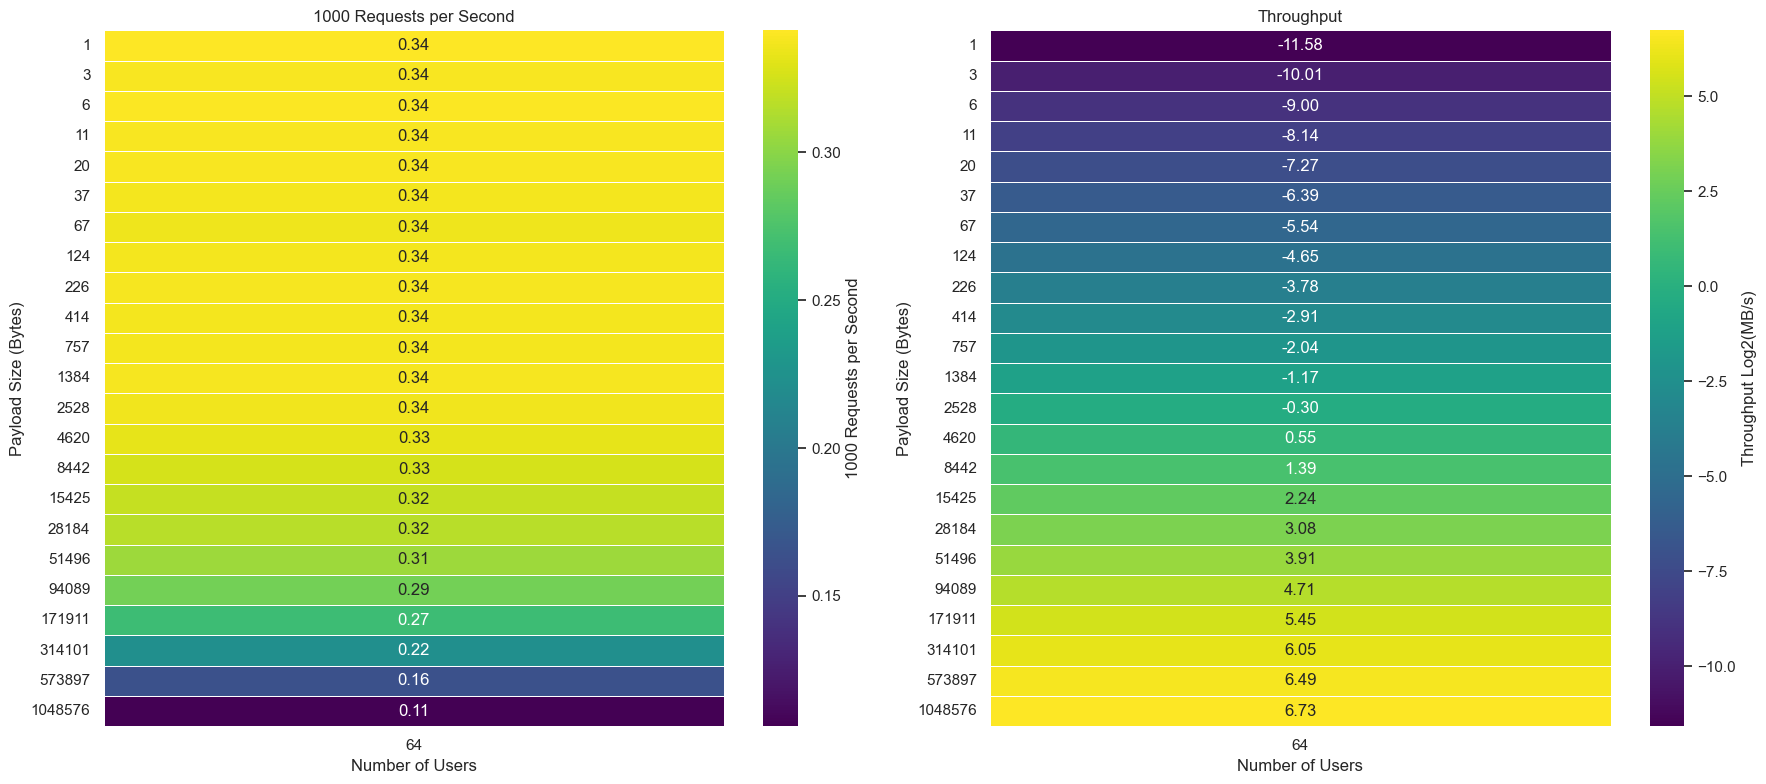

In [18]:
# Add columns for requests per second and requests per second
results_df['requests_per_second'] = results_df['total_requests'] / run_time_seconds / 1000

#results_df['avg_response_time_per_user'] = results_df['avg_response_time'] / results_df['num_users']
results_df['med_response_time_per_user'] = results_df['med_response_time'] / results_df['num_users']
results_df['throughput'] = results_df['total_requests'] / run_time_seconds * results_df['payload_size'] / 1024 / 1024 # MB/s

# Pivot the DataFrames for the heatmaps
heatmap_data_rps = results_df.pivot(index="payload_size", columns="num_users", values="requests_per_second")
heatmap_data_rt = results_df.pivot(index="payload_size", columns="num_users", values="throughput")

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Draw the heatmap for average response time
sns.heatmap(heatmap_data_rps, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "1000 Requests per Second"}, ax=axes[0])
axes[0].set_title('1000 Requests per Second')
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Payload Size (Bytes)')

# Draw the heatmap for requests per second per user
log_heatmap_data = np.log2(heatmap_data_rt + 1e-6)
sns.heatmap(log_heatmap_data, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "Throughput Log2(MB/s)"}, ax=axes[1])
axes[1].set_title('Throughput')
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Payload Size (Bytes)')

plt.tight_layout()
plt.show()


In [19]:
print( results_df['num_users'])

0     64
1     64
2     64
3     64
4     64
5     64
6     64
7     64
8     64
9     64
10    64
11    64
12    64
13    64
14    64
15    64
16    64
17    64
18    64
19    64
20    64
21    64
22    64
Name: num_users, dtype: int64


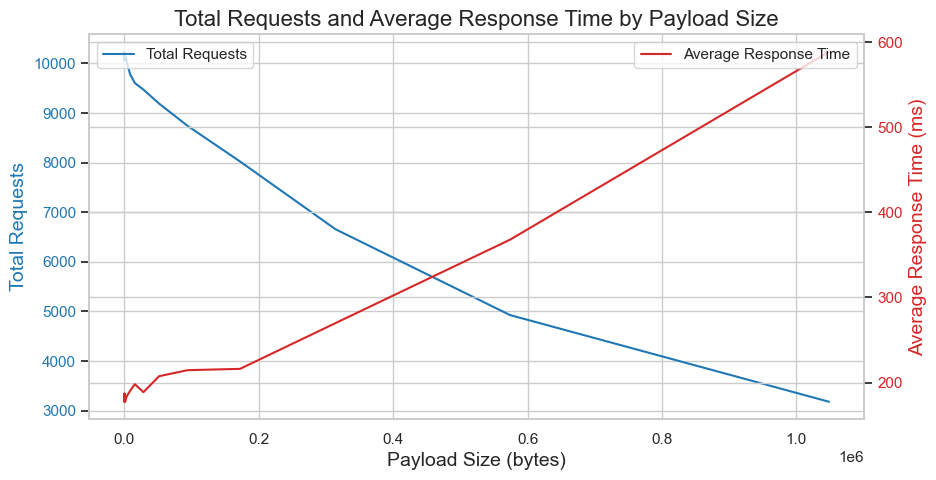

In [20]:
# Assuming 'results_df' is your DataFrame

# First, we will group the data by 'payload_size' and calculate the mean 'total_requests' and 'avg_response_time'.
# This is necessary because your data seems to have multiple entries for each 'payload_size'.
grouped = results_df.groupby('payload_size').mean().reset_index()

# Now let's plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# Set the x-axis label
ax1.set_xlabel('Payload Size (bytes)', fontsize=14)

# Plot the 'total_requests' on the left y-axis
ax1.set_ylabel('Total Requests', color='tab:blue', fontsize=14)
ax1.plot(grouped['payload_size'], grouped['total_requests'], color='tab:blue', label='Total Requests')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to share the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Average Response Time (ms)', color='tab:red', fontsize=14)  # we already handled the x-label with ax1
ax2.plot(grouped['payload_size'], grouped['avg_response_time'], color='tab:red', label='Average Response Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title of the plot
plt.title('Total Requests and Average Response Time by Payload Size', fontsize=16)

# Show a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()